In [10]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch_directml

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# dml = torch_directml.device()
# device = dml

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


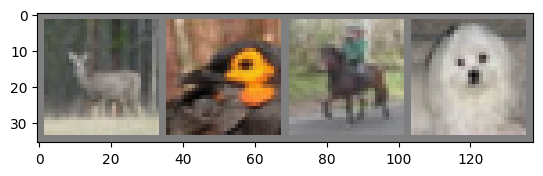

deer  bird  horse dog  


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [16]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.164
[1,  4000] loss: 1.809
[1,  6000] loss: 1.649
[1,  8000] loss: 1.583
[1, 10000] loss: 1.511
[1, 12000] loss: 1.480
[2,  2000] loss: 1.399
[2,  4000] loss: 1.366
[2,  6000] loss: 1.352
[2,  8000] loss: 1.315
[2, 10000] loss: 1.315
[2, 12000] loss: 1.294
[3,  2000] loss: 1.228
[3,  4000] loss: 1.214
[3,  6000] loss: 1.213
[3,  8000] loss: 1.210
[3, 10000] loss: 1.190
[3, 12000] loss: 1.185
[4,  2000] loss: 1.127
[4,  4000] loss: 1.126
[4,  6000] loss: 1.120
[4,  8000] loss: 1.116
[4, 10000] loss: 1.098
[4, 12000] loss: 1.120
[5,  2000] loss: 1.034
[5,  4000] loss: 1.021
[5,  6000] loss: 1.062
[5,  8000] loss: 1.044
[5, 10000] loss: 1.068
[5, 12000] loss: 1.067
[6,  2000] loss: 0.972
[6,  4000] loss: 0.961
[6,  6000] loss: 0.999
[6,  8000] loss: 1.020
[6, 10000] loss: 1.023
[6, 12000] loss: 1.002
[7,  2000] loss: 0.903
[7,  4000] loss: 0.945
[7,  6000] loss: 0.957
[7,  8000] loss: 0.962
[7, 10000] loss: 0.957
[7, 12000] loss: 0.971
[8,  2000] loss: 0.867
[8,  4000] 

In [19]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

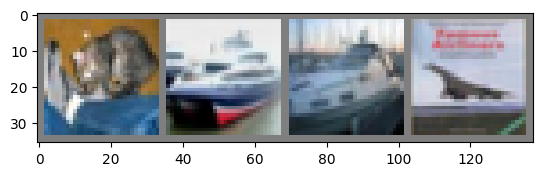

GroundTruth:  cat   ship  ship  plane


In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   ship  plane plane


In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [25]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.9 %
Accuracy for class: car   is 66.1 %
Accuracy for class: bird  is 46.0 %
Accuracy for class: cat   is 28.9 %
Accuracy for class: deer  is 42.7 %
Accuracy for class: dog   is 57.2 %
Accuracy for class: frog  is 66.4 %
Accuracy for class: horse is 59.3 %
Accuracy for class: ship  is 70.7 %
Accuracy for class: truck is 60.9 %


In [26]:
del dataiter